In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt

In [2]:
import sys
import pickle
import numpy as np
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from tester import test_classifier

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier

In [3]:
my_dataset = pickle.load(open("my_complete_dataset.pkl", "r") )

feature_names = np.array(pickle.load(open("my_feature_names.pkl")) + ['rand1','rand2','rand3'])

data = featureFormat(my_dataset, feature_names[:-3])
labels, features = targetFeatureSplit(data)
features = np.array(features)
# features = MinMaxScaler().fit_transform(features)

In [4]:
cv = StratifiedShuffleSplit(labels, n_iter=1000, 
                            random_state=42)

In [5]:
def plot_importances(imps, fname=None):
    F = np.array(feature_names[1:])
    
    d = np.reshape(imps, ((-1,len(F))))
    
    order = np.argsort(np.mean(d, 0))
    
    d = d[:,order]

    fig = plt.figure(figsize=(16,10))
    plt.boxplot(np.array(d))
    ax1 = plt.gca()
    xtickNames = plt.setp(ax1,xticklabels=F[order])
    _ = plt.setp(xtickNames, rotation=45, fontsize=8)
    if fname:
        fig.savefig(fname)


In [44]:
def feature_imp_cv(clf,prop,D,Y,cv):
    imps = []
    for train, test in cv:
        nclf = clf.fit(D[train], Y[train])
        imps.append(getattr(nclf,prop))
    imps = np.array(imps)
    imps[np.isnan(imps)] = 0
    return imps

def multiple_tries(clf,prop,D,Y,cv,k,N):
    all_imps = []
    all_sel = []
    for i in range(N):
        imps = feature_imp_cv(clf,prop,D,Y,cv)

        sorted_imps, sorted_inds = zip(*sorted(zip(np.mean(imps,0), range(len(imps))), reverse=True))

        best_k = sorted_inds[:k]
        
        all_imps.append(imps)
        all_sel.append(best_k)
        
    return all_imps, all_sel
                                   
def union_intersection_sets(all_sets):
    union_set = set()
    intersection_set = set(all_sets[0])
    for s in all_sets:
        s_set = set(s)
        union_set = union_set.union(s_set)
        intersection_set = intersection_set.intersection(s_set)
    print 'Length of Union Set', len(union_set)
    print 'Length of Intersection Set', len(intersection_set)
    return union_set, intersection_set



In [45]:
rand_features =  np.random.rand(np.shape(data)[0],3)
D = np.concatenate((np.array(features),rand_features), axis=1)
Y = np.array(labels)

In [57]:
k=10
N=1

## Decision Tree Feature Selection

In [58]:
dtree_imps, dtree_inds = multiple_tries(DecisionTreeClassifier(),'feature_importances_',D,Y,cv,k=k,N=N)
union_dtree, intersection_dtree = union_intersection_sets(dtree_inds)

Length of Union Set 10
Length of Intersection Set 10


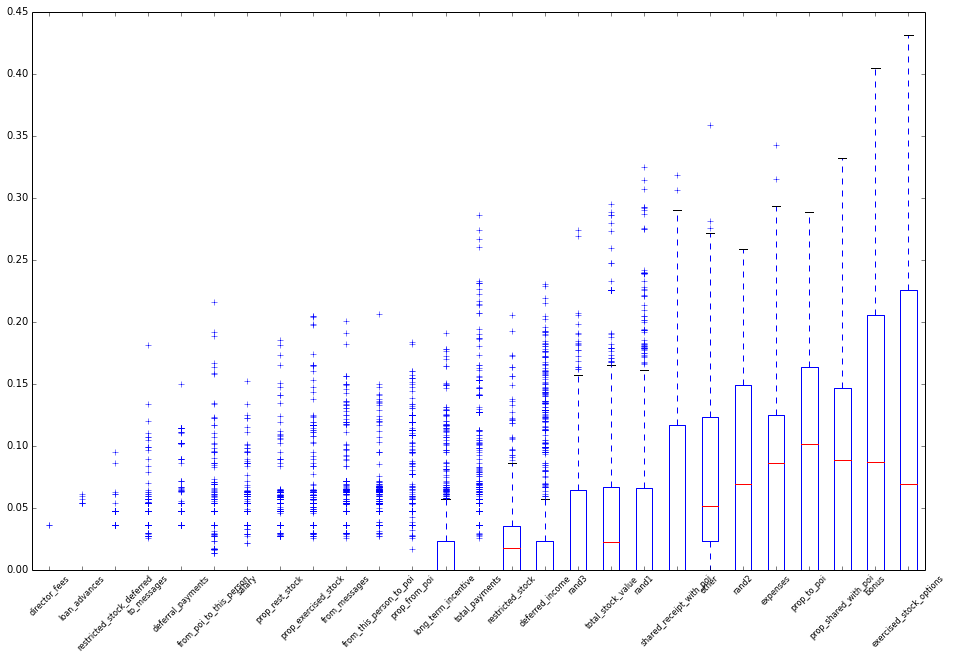

In [59]:
plot_importances(dtree_imps)

In [60]:
print feature_names[1:][list(intersection_dtree)]

['exercised_stock_options' 'bonus' 'total_stock_value' 'expenses' 'other'
 'shared_receipt_with_poi' 'prop_to_poi' 'prop_shared_with_poi' 'rand1'
 'rand2']


There is huge variance in the decision tree estimates of feature importances. Let's see how good this cross-validation was at estimating the feature importances on the entire dataset. Notice that the random features are being given non-zero imporances. And in fact show up (twice) in the top 10 features.

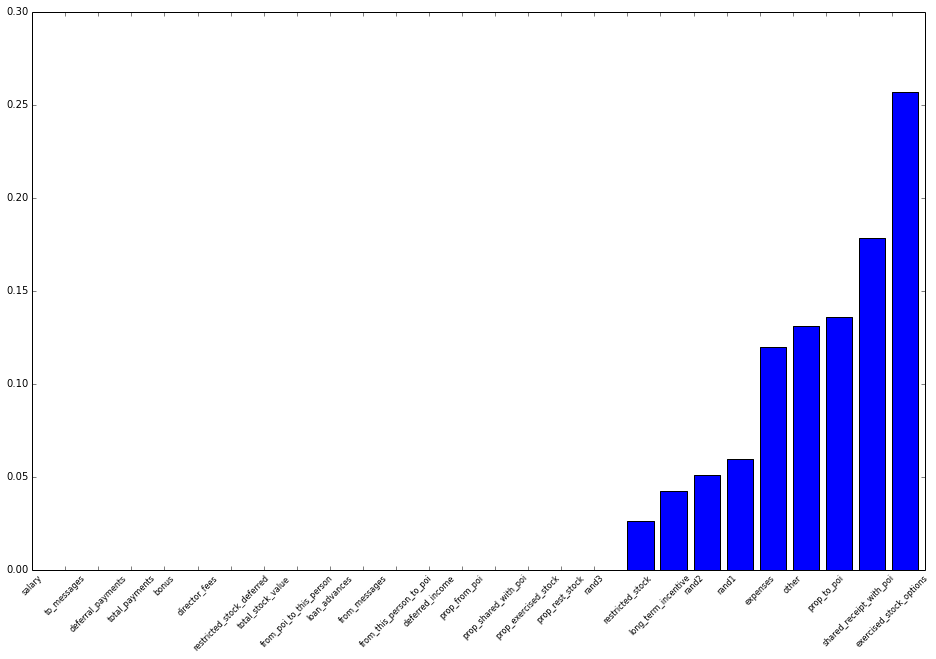

In [61]:
clf = DecisionTreeClassifier().fit(D,Y)
imps, inds = zip(*sorted(zip(clf.feature_importances_, range(1,len(feature_names)))))

fig = plt.figure(figsize=(16,10))
plt.bar(height=imps, left=range(27))
ax1 = plt.gca()
ax1.set_xticks(range(27))
xtickNames = plt.setp(ax1,xticklabels=feature_names[list(inds)])
_ = plt.setp(xtickNames, rotation=45, fontsize=8)


## KBest - ANOVA

In [63]:
anova_imps, anova_inds = multiple_tries(SelectKBest(),'scores_',D,Y,cv,k=k,N=N)
union_anova,intersection_anova = union_intersection_sets(anova_inds)

Length of Union Set 10
Length of Intersection Set 10


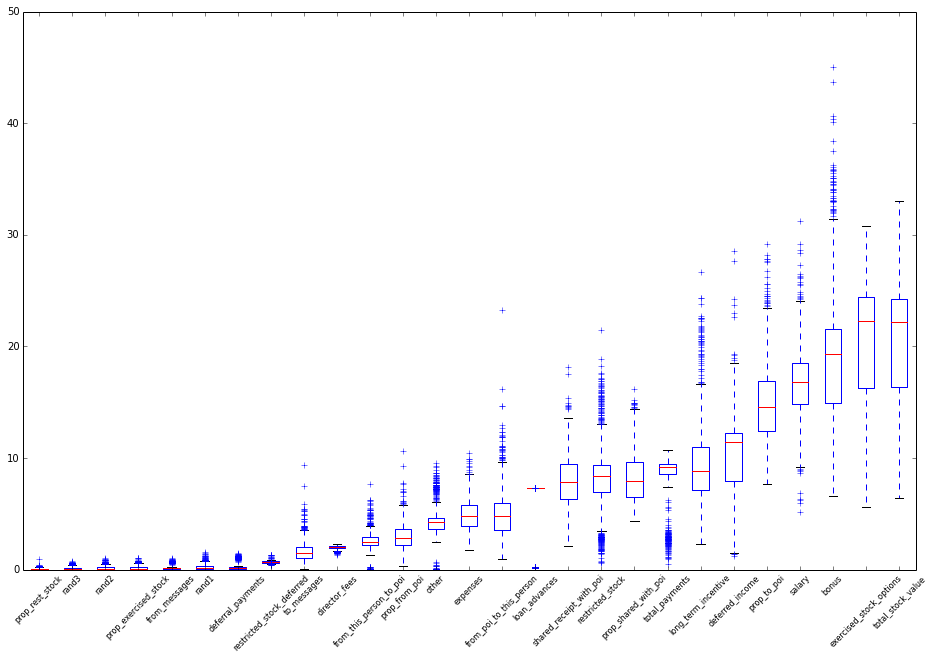

In [64]:
plot_importances(anova_imps)

In [65]:
print feature_names[1:][list(intersection_anova)]

['salary' 'total_payments' 'exercised_stock_options' 'bonus'
 'total_stock_value' 'deferred_income' 'restricted_stock'
 'long_term_incentive' 'prop_to_poi' 'prop_shared_with_poi']


In this case the estimates have less variance, and are pretty much consistent with the conducting the test on the full dataset. Unfortunately, the ANOVA test does not capture any interplay between features.

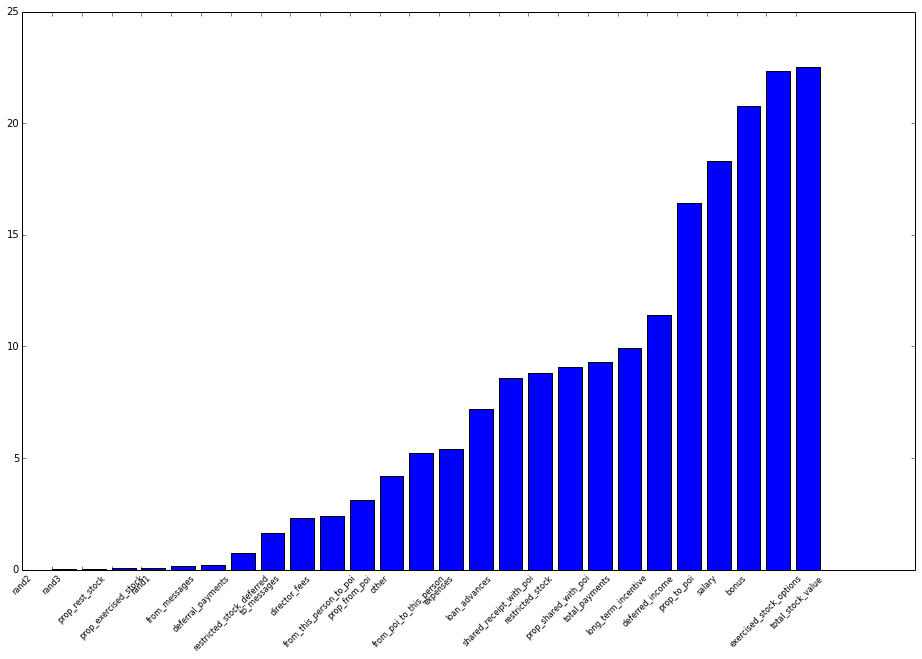

In [66]:
clf = SelectKBest().fit(D,Y)
imps, inds = zip(*sorted(zip(clf.scores_, range(1,len(feature_names)))))

fig = plt.figure(figsize=(16,10))
plt.bar(height=imps, left=range(27))
ax1 = plt.gca()
ax1.set_xticks(range(27))
xtickNames = plt.setp(ax1,xticklabels=feature_names[list(inds)])
_ = plt.setp(xtickNames, rotation=45, fontsize=8)

## Agreement

In [71]:
intersection = intersection_anova.intersection(intersection_dtree)
union = union_anova.union(union_dtree)

print 'Length of Intersection Set', len(intersection)
print 'Lenght of Union Set', len(union)
print 'Agreement', 1.*len(intersection)/len(union)

Length of Intersection Set 5
Lenght of Union Set 15
Agreement 0.333333333333


In [72]:
print feature_names[1:][list(intersection)]

['total_stock_value' 'prop_to_poi' 'exercised_stock_options' 'bonus'
 'prop_shared_with_poi']


In [73]:
print feature_names[1:][list(union)]

['salary' 'total_payments' 'exercised_stock_options' 'bonus'
 'total_stock_value' 'expenses' 'other' 'deferred_income'
 'shared_receipt_with_poi' 'restricted_stock' 'long_term_incentive'
 'prop_to_poi' 'prop_shared_with_poi' 'rand1' 'rand2']
